In [2]:
from IPython.display import Image

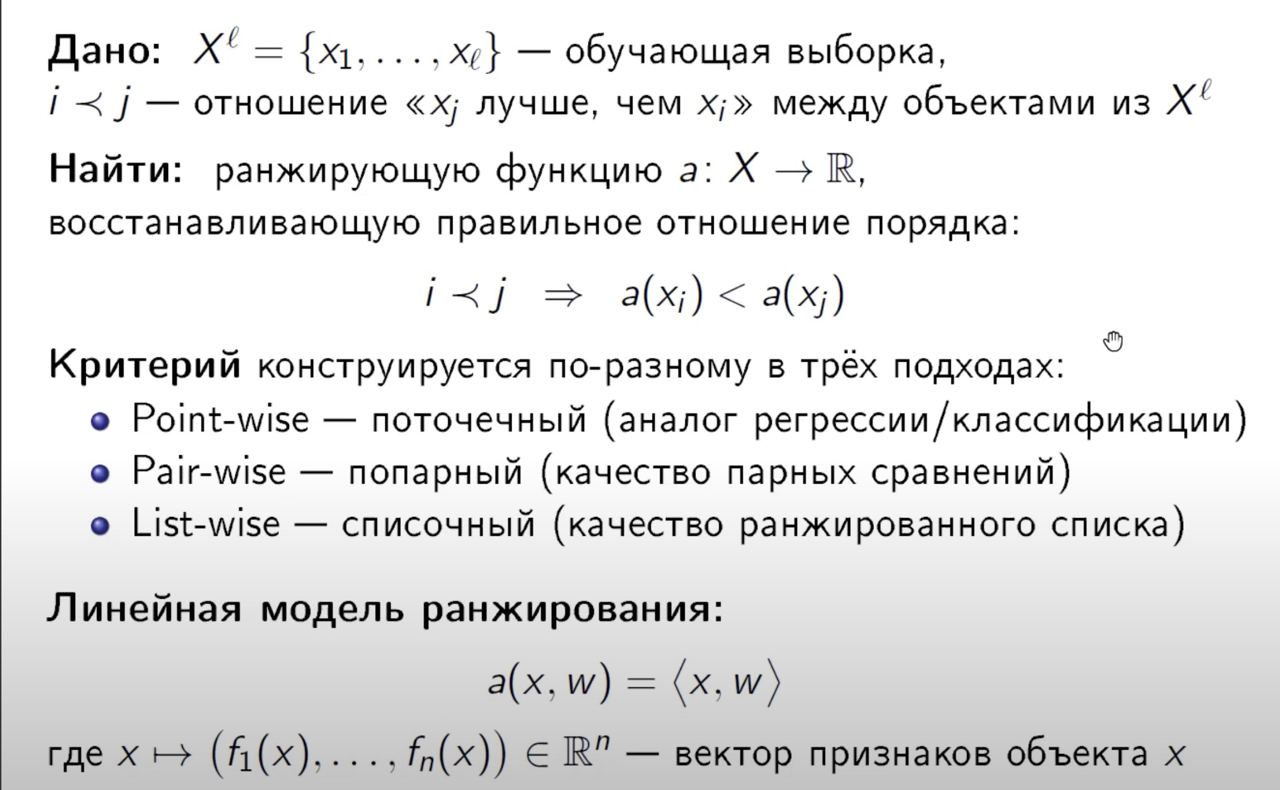

In [5]:
Image('/content/1.jpg')

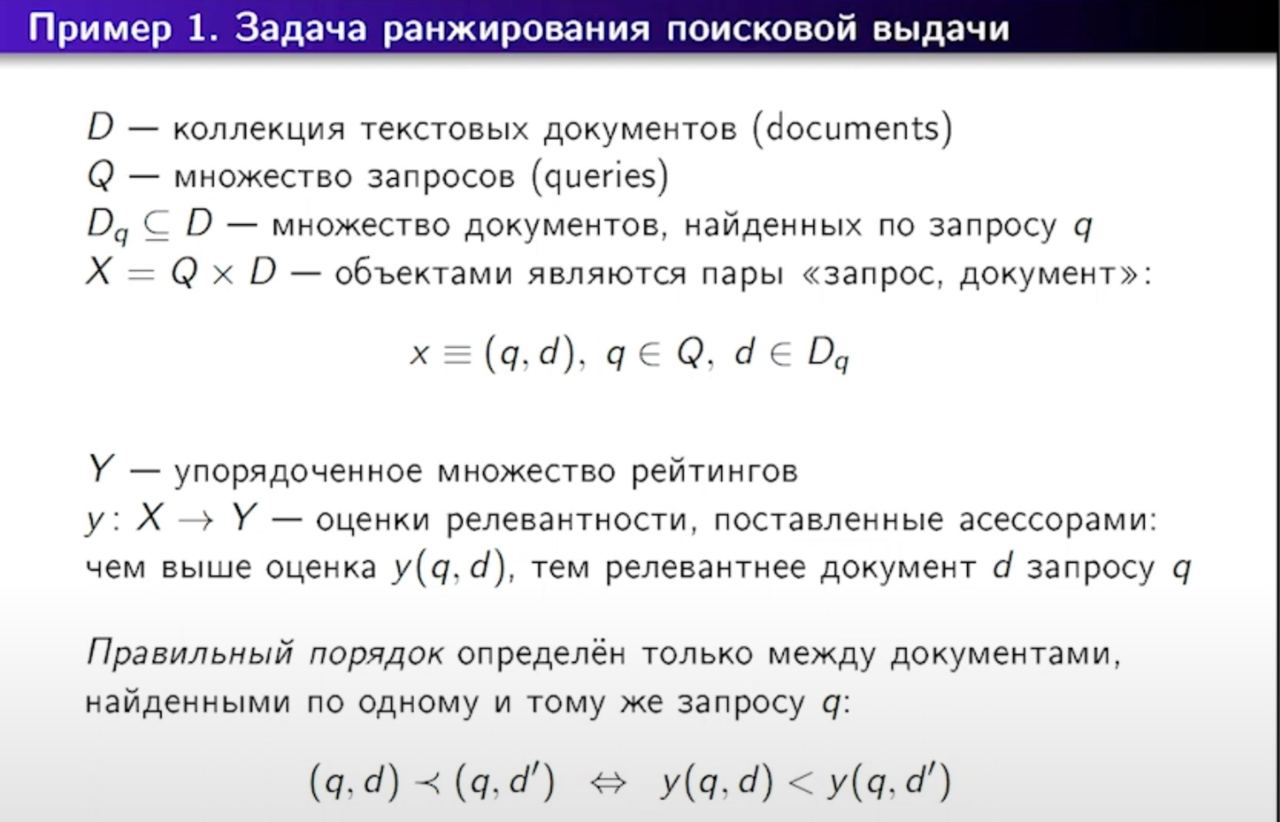

In [6]:
Image('/content/2.jpg')

[Ссылка](https://www.microsoft.com/en-us/research/project/mslr/) на данные. <br>
[Ссылка](https://drive.google.com/drive/folders/1qoIgZWJAr6weWhYebZQiYBlFqwVNDDOj) на мой драйв, где лежат данные.

In [7]:
import pandas as pd

In [9]:
columns = ['relevance', 'query_id'] + [f"feature{i}" for i in range(1,137)]
train_df = pd.read_csv("/content/drive/MyDrive/data/train.txt", sep=" ", index_col=False, names=columns, nrows=30000)
test_df = pd.read_csv("/content/drive/MyDrive/data/test.txt", sep=" ", index_col=False, names=columns, nrows=7500)

In [11]:
train_df.iloc[:,1:] = train_df.iloc[:,1:].applymap(lambda x: x.split(':')[1])
test_df.iloc[:,1:] = test_df.iloc[:,1:].applymap(lambda x: x.split(':')[1])

In [12]:
train_df.sample(3)

,relevance,query_id,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,...,feature127,feature128,feature129,feature130,feature131,feature132,feature133,feature134,feature135,feature136
11626,1,1516,2,0,1,1,2,1,0,0.50000,...,15,31,1,12855,4010,5,14,0,0,0
11524,0,1501,4,0,2,1,4,1,0,0.50000,...,55,24,13,1386,9595,9,45,0,0,0
26687,2,3526,1,0,1,1,1,1,0,1,...,11,0,9,57455,17602,2,6,0,3,2.86666666666666


In [13]:
train_df.relevance.describe()

count    30000.00000
mean         0.58520
std          0.79063
min          0.00000
25%          0.00000
50%          0.00000
75%          1.00000
max          4.00000
Name: relevance, dtype: float64

In [15]:
train_df.relevance.value_counts()

0    17335
1     8460
2     3677
3      370
4      158
Name: relevance, dtype: int64

# Попарные методы
Вспомним, что изначально мы определяли задачу ранжирования через пары объектов. Если записывать это формально, то получим функционал ошибки
$$ \sum_{(i,j )∈R}{[a(x_j)−a(x_i)<0]} $$
где R — множество пар, для которых известен порядок. Этот функционал не является дифференцируемым, но мы уже решали такую проблему в линейной классификации — надо заменить индикатор ошибки [z < 0] на его гладкую верхнюю оценку L(z):
$$ \sum_{(i,j )∈R} {[a(xj)−a(xi)<0]} <= \sum_{(i,j )∈R} {L(a(x_j)−a(x_i))} $$
В качестве оценки L(z) можно брать, например, логистическую функцию
$$ L(x) = log(1+e^{−σz} ) $$
с параметром σ > 0 — в этом случае получим метод RankNet. Оптимизировать данный функционал можно обычным стохастическим градиентным спуском. Если использовать линейную модель a(x) = ⟨w, x⟩, то один шаг будет иметь вид
$$ w:=w + η\frac {σ} {1+exp(σ⟨x_j − x_i,w⟩)}(x_j −x_i) $$

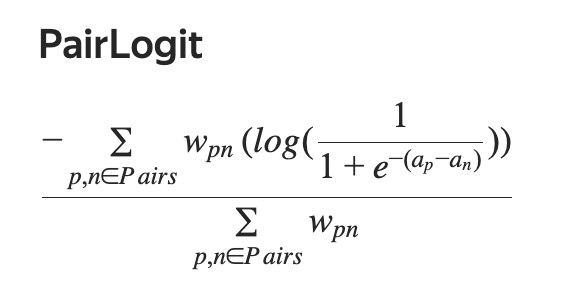

In [53]:
Image('/content/3.jpg')

In [31]:
train_df['doc_id'] = train_df.iloc[:, 2:].apply(lambda row: hash(tuple(row)), axis=1)

In [32]:
train_df[['relevance',	'query_id', 'doc_id']]

,relevance,query_id,doc_id
0,2,1,1226404944246806799
1,2,1,1929045030535519746
2,0,1,8503077920557580425
3,2,1,5505560320391907083
4,1,1,-6562683871010519762
...,...,...,...
29995,1,3976,-8517936157676471480
29996,0,3976,8370929177363914556
29997,0,3976,-5862065866333125396
29998,0,3976,-8307134187680062613


In [36]:
train_merge = train_df[['relevance',	'query_id', 'doc_id']].merge(train_df[['relevance',	'query_id', 'doc_id']], 'inner', 'query_id')

In [38]:
train_merge = train_merge[train_merge.relevance_x > train_merge.relevance_y]

In [45]:
pairs_df = train_merge.sample(frac=1)

In [49]:
pairs_df

,relevance_x,query_id,doc_id_x,relevance_y,doc_id_y
3103197,1,2821,-8205578557482892218,0,5243416913683828913
9577,1,16,6067376761982298447,0,7417729908812823242
1181878,2,946,-5985577950590078209,0,-3771394477536334288
3720687,1,3406,-8778745606635070915,0,4652657057427771393
808866,1,646,-773157686872549379,0,8509115796903746692
...,...,...,...,...,...
797456,2,631,8752810979100211478,0,-6394032472198781693
830601,1,676,-537059358628581998,0,1417084247992916106
3653426,1,3376,7021084501139139323,0,-8426479126140177501
3542944,1,3241,7308459593666813381,0,7586143723523074155


In [46]:
from tqdm import tqdm
import numpy as np

In [50]:
def batch_sampler(batch_size, train_df, pairs_df):
    for i in tqdm(range(len(pairs_df) // batch_size), bar_format='Batch sampler {l_bar}{bar}{r_bar}'):
        batch = pairs_df[i*batch_size:(i+1)*batch_size]
        batch = batch.merge(train_df.iloc[:,1:].rename(columns={'doc_id': 'doc_id_x'}), on=['doc_id_x', 'query_id'])
        batch = batch.merge(train_df.iloc[:,1:].rename(columns={'doc_id': 'doc_id_y'}), on=['doc_id_y', 'query_id']).drop_duplicates()
        batch_x = batch.iloc[:,5:]
        yield (np.stack((batch_x.iloc[:,:136].to_numpy(), batch_x.iloc[:,136:].to_numpy()), axis=1).astype(float),
            np.stack((batch['relevance_x'].to_numpy(), batch['relevance_y'].to_numpy()), axis=1).astype(int))

batch_x, batch_y = batch_sampler(6, train_df, pairs_df).__next__()

Batch sampler   0%|          | 0/183752 [00:00<?, ?it/s]


In [51]:
batch_x

array([[[ 2. ,  0. ,  1. , ...,  0. ,  4. ,  6.3],
        [ 2. ,  0. ,  1. , ...,  0. ,  4. ,  9.6]],

       [[ 6. ,  0. ,  2. , ...,  0. ,  0. ,  0. ],
        [ 7. ,  0. ,  2. , ...,  0. ,  0. ,  0. ]],

       [[ 2. ,  0. ,  2. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]],

       [[ 3. ,  0. ,  3. , ...,  0. ,  0. ,  0. ],
        [ 2. ,  1. ,  2. , ...,  0. ,  0. ,  0. ]],

       [[ 1. ,  0. ,  0. , ...,  0. ,  4. , 27.9],
        [ 3. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]],

       [[ 3. ,  0. ,  3. , ...,  0. ,  0. ,  0. ],
        [ 2. ,  2. ,  2. , ...,  0. ,  0. ,  0. ]]])

In [52]:
batch_x.shape

(6, 2, 136)

In [ ]:
class LogReg:

    def __init__(self):
        self.w = np.array([])

    @staticmethod
    def batch_sampler(batch_size, train_df, pairs_df):
        for i in tqdm(range(len(pairs_df) // batch_size), bar_format='Batch sampler {l_bar}{bar}{r_bar}'):
            batch = pairs_df[i*batch_size:(i+1)*batch_size]
            batch = batch.merge(train_df.iloc[:,1:].rename(columns={'doc_id': 'doc_id_x'}), on=['doc_id_x', 'query_id'])
            batch = batch.merge(train_df.iloc[:,1:].rename(columns={'doc_id': 'doc_id_y'}), on=['doc_id_y', 'query_id']).drop_duplicates()
            batch_x = batch.iloc[:,5:]
            yield (np.stack((batch_x.iloc[:,:136].to_numpy(), batch_x.iloc[:,136:].to_numpy()), axis=1).astype(float),
                np.stack((batch['relevance_x'].to_numpy(), batch['relevance_y'].to_numpy()), axis=1).astype(int))

    def fit(self, x, y, n, batch_sampler=True):



In [70]:
class RankNet:

  def __init__(self, features_cnt):
      self.weights = np.random.normal(size=features_cnt)

  def batch_norm(self, features):
    return (features - np.mean(features, axis=(0,1))) / np.std(features, axis=(0,1))

  def pair_logit_loss(self, batch_x, batch_y):
    positive_sample = np.dot(batch_x[:,0,:], self.weights)
    negative_sample = np.dot(batch_x[:,1,:], self.weights)
    pair_weights = batch_y[:,0] - batch_y[:,1]
    return np.sum(np.multiply(pair_weights, np.log(1 + np.exp(-1*(positive_sample - negative_sample))))) / np.sum(pair_weights)

  def fit(self, train_df, pairs_df, batch_size, lr=0.1, logging_period = 10):
    step = 0
    for batch_x, batch_y in batch_sampler(batch_size, train_df, pairs_df):
        input = self.batch_norm(batch_x)

        if not (step % logging_period):
          tqdm.write(f'loss: {self.pair_logit_loss(input, batch_y)}')
        step += 1

        positive_sample = np.dot(input[:,0,:], self.weights)
        negative_sample = np.dot(input[:,1,:], self.weights)
        grad = -1 * np.dot(1 / (1+np.exp(positive_sample - negative_sample)), (input[:,0,:] - input[:,1,:]))
        self.weights -= lr * grad

rank_net = RankNet(136)

In [71]:
rank_net.fit(train_df, pairs_df, 128)

Batch sampler   0%|          | 1/8613 [00:00<1:26:42,  1.66it/s]

loss: 3.522721158376806


Batch sampler   0%|          | 11/8613 [00:06<1:30:16,  1.59it/s]

loss: 14.246393509778052


Batch sampler   0%|          | 15/8613 [00:09<1:47:07,  1.34it/s]<ipython-input-70-024a70cb517f>:26: RuntimeWarning: overflow encountered in exp
  grad = -1 * np.dot(1/(1+np.exp(positive_sample - negative_sample)), (input[:,0,:] - input[:,1,:]))
Batch sampler   0%|          | 21/8613 [00:13<1:25:26,  1.68it/s]

loss: 20.24590573228403


Batch sampler   0%|          | 31/8613 [00:18<1:21:41,  1.75it/s]

loss: 14.704793469679027


Batch sampler   0%|          | 41/8613 [00:25<1:26:41,  1.65it/s]

loss: 18.873587600813778


Batch sampler   1%|          | 51/8613 [00:32<1:54:05,  1.25it/s]

loss: 4.243177537594997


Batch sampler   1%|          | 61/8613 [00:40<1:48:47,  1.31it/s]

loss: 25.518420065898024


Batch sampler   1%|          | 71/8613 [00:46<1:26:59,  1.64it/s]

loss: 24.054535458875538


Batch sampler   1%|          | 76/8613 [00:50<1:35:24,  1.49it/s]


KeyboardInterrupt: 

In [66]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 3.0 MB/s eta 0:00:00


In [67]:
from catboost import CatBoostRanker

catboost_ranker = CatBoostRanker(loss_function='PairLogit')

catboost_ranker.fit(train_df.iloc[:,2:-1], train_df.iloc[:,0], group_id=train_df.iloc[:,1], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6916547	total: 657ms	remaining: 10m 56s
1:	learn: 0.6893460	total: 1.69s	remaining: 14m
2:	learn: 0.6877864	total: 2.71s	remaining: 15m 1s
3:	learn: 0.6858315	total: 3.71s	remaining: 15m 23s
4:	learn: 0.6846163	total: 5.04s	remaining: 16m 43s
5:	learn: 0.6825843	total: 6.59s	remaining: 18m 12s
6:	learn: 0.6809216	total: 8.02s	remaining: 18m 58s
7:	learn: 0.6794158	total: 10.8s	remaining: 22m 18s
8:	learn: 0.6781483	total: 13.7s	remaining: 25m 6s
9:	learn: 0.6766989	total: 15.9s	remaining: 26m 11s
10:	learn: 0.6750872	total: 16.8s	remaining: 25m 6s
11:	learn: 0.6737651	total: 17.3s	remaining: 23m 46s
12:	learn: 0.6723338	total: 17.9s	remaining: 22m 38s
13:	learn: 0.6710723	total: 18.5s	remaining: 21m 41s
14:	learn: 0.6697559	total: 19s	remaining: 20m 49s
15:	learn: 0.6686329	total: 19.6s	remaining: 20m 5s
16:	learn: 0.6671255	total: 20.2s	remaining: 19m 25s
17:	learn: 0.6663789	total: 20.7s	remaining: 18m 51s
18:	learn: 0.6649743	total: 21.3s	remaining: 18m 19s
19:	learn: 0.

KeyboardInterrupt: 